# Object Detection with YOLOv8 using Ultralytics

### Author: Kavin Fidel J


In [54]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [55]:



import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import json
import yaml


import random
random.seed(42)

Ultralytics 8.3.55 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 30.9 GB RAM, 46.3/411.4 GB disk)


In [56]:
import os
import shutil
from tqdm import tqdm

from pycocotools.coco import COCO

In [57]:

train_dir='./Car-Parts-Segmentation/trainingset'
train_data='./Car-Parts-Segmentation/trainingset/JPEGImages'
train_annotation_file = './Car-Parts-Segmentation/trainingset/annotations.json'

In [58]:
test_dir='./Car-Parts-Segmentation/testset'
test_data='./Car-Parts-Segmentation/testset/JPEGImages'
test_annotation_file = './Car-Parts-Segmentation/testset/annotations.json'

## Formatting the Annotation files

In [62]:

def formatting(annot_file, labels):
    coco = COCO(annot_file)
    os.makedirs(labels, exist_ok = True)

    cat_mapping = {cat['id']: idx for idx, cat in enumerate(coco.loadCats(coco.getCatIds()))}
    # cat mapping starts from zero

    for img_id in tqdm(coco.getImgIds(), desc = "COCO ---> YOLO"):
        img_info = coco.loadImgs(img_id)[0]
        img_name = img_info['file_name']
        width = img_info['width']
        height = img_info['height']

        annotations = coco.loadAnns(coco.getAnnIds(imgIds = img_id))
        

        new_annotations = []
        for annot in annotations:
            cat_id = annot['category_id']
            bbox = annot['bbox']

            x_min, y_min, box_width, box_height = bbox
            x_centre = (x_min + box_width /2) / width
            y_centre = (y_min + box_height /2 ) / height
            box_width /= width
            box_height /= height

            class_id = cat_mapping[cat_id]

            new_annotations.append(f"{class_id} {x_centre} {y_centre} {box_width} {box_height}")
        
        out_file_path = os.path.join(labels, f"{os.path.splitext(img_name)[0]}.txt")
        with open(out_file_path, 'w') as f:
            print('debug2')
            f.write("\n".join(new_annotations))

    



In [63]:
formatting(train_annotation_file, './train_labels')
formatting(test_annotation_file, './test_labels')

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


COCO ---> YOLO: 100%|██████████| 400/400 [00:00<00:00, 5983.57it/s]


debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2

COCO ---> YOLO: 100%|██████████| 100/100 [00:00<00:00, 5576.57it/s]

debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2
debug2


In [ ]:
def coco_organizer(image_dir, labels_dir, output_dir, annotation_file, split_ratio=0.2):
   
    subdirs = {"images": os.path.join(output_dir, "images"), "labels": os.path.join(output_dir, "labels")}
    for subdir in subdirs.values():
        os.makedirs(subdir, exist_ok=True)

    
    coco = COCO(annotation_file)
    image_ids = coco.getImgIds()
    random.shuffle(image_ids)


    split_idx = int(len(image_ids) * split_ratio)
    splits = {
        './train': image_ids[split_idx:], 
        './val': image_ids[:split_idx], 
        './test': image_ids
    }

    
    target_image_ids = splits.get(output_dir, [])

    
    for image_id in tqdm(target_image_ids, desc=f"Organizing data into {output_dir}"):
        image_info = coco.loadImgs(image_id)[0]
        image_name = image_info['file_name']
        label_name = os.path.splitext(image_name)[0] + ".txt"

        for src, dest_dir in [(os.path.join(image_dir, image_name), subdirs["images"]),
                              (os.path.join(labels_dir, label_name), subdirs["labels"])]:
            if os.path.exists(src):
                shutil.copy(src, dest_dir)


In [ ]:
coco_organizer(train_data, './train_labels', './train', train_annotation_file)
coco_organizer(train_data, './train_labels', './val', train_annotation_file)
coco_organizer(test_data, './test_labels', './test', test_annotation_file)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Organizing data into ./train: 100%|██████████| 320/320 [00:00<00:00, 1750.23it/s]


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Organizing data into ./val: 100%|██████████| 80/80 [00:00<00:00, 2680.43it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Organizing data into ./test: 100%|██████████| 100/100 [00:00<00:00, 1426.51it/s]


In [ ]:
def yaml_utils(yaml_path):
    
    coco = COCO(train_annotation_file)
    categories = coco.loadCats(coco.getCatIds())
    
   
    content = {
        "train": os.path.abspath("./train"),
        "val": os.path.abspath("./val"),
        "nc": len(categories),  
        "names": [cat['name'] for cat in categories] 
    }

  
    with open(yaml_path, "w") as yaml_file:
        yaml.dump(content, yaml_file, default_flow_style=False)


yaml_utils('./train_data.yaml')


loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


## YOLO Training

In [ ]:
data_yaml_path = './train_data.yaml'

model = YOLO('yolov8s.pt')
model.train(data=data_yaml_path, epochs=25, imgsz=640)

100%|██████████| 21.5M/21.5M [00:00<00:00, 204MB/s]


Ultralytics 8.3.55 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./train_data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

100%|██████████| 755k/755k [00:00<00:00, 110MB/s]

Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2123401  ultralytics.nn.modules.head.Detect           [19, [128, 256, 512]]         
Model summary: 225 layers, 11,142,953 parameters, 11,142,937 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 175MB/s]


AMP: checks passed ✅


train: Scanning /teamspace/studios/this_studio/train/labels... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<00:00, 1413.18it/s]

train: New cache created: /teamspace/studios/this_studio/train/labels.cache



val: Scanning /teamspace/studios/this_studio/val/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 887.61it/s]

val: New cache created: /teamspace/studios/this_studio/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.27G      1.645      4.512      1.684        224        640: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.26s/it]

                   all         80        634      0.119      0.329      0.156      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.22G      1.164      2.486      1.309        195        640: 100%|██████████| 20/20 [00:04<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         80        634      0.406      0.519      0.428      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.24G     0.9734      1.745       1.16        201        640: 100%|██████████| 20/20 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]

                   all         80        634      0.406      0.661      0.501      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.38G     0.9318      1.503       1.13        205        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         80        634      0.482      0.707      0.571      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.24G     0.8515      1.289      1.077        185        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         80        634      0.515      0.744      0.638      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.37G     0.8365      1.188      1.069        205        640: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]

                   all         80        634      0.609      0.744      0.697      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25       4.4G     0.8032       1.12      1.042        202        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.58it/s]

                   all         80        634      0.556      0.821      0.687      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.37G     0.7978      1.077      1.038        221        640: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         80        634      0.639      0.824      0.738      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.37G      0.778      1.029      1.036        213        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         80        634       0.66      0.797      0.762      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.37G     0.7679     0.9815      1.027        185        640: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         80        634      0.667      0.832      0.788      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.37G     0.7293     0.9565      1.008        188        640: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         80        634      0.635      0.881      0.773      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.22G     0.7332     0.9207       1.01        245        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         80        634      0.627      0.875      0.756      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.22G     0.7191     0.9002     0.9971        151        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         80        634      0.696       0.87      0.761       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.22G     0.6917     0.8288     0.9887        206        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         80        634      0.701      0.855      0.796      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.37G     0.6768     0.8047     0.9788        206        640: 100%|██████████| 20/20 [00:04<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]

                   all         80        634      0.748      0.861      0.824      0.709


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.21G     0.6514     0.8206     0.9698        123        640: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         80        634       0.71      0.878      0.812      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.21G     0.6208     0.7644       0.95        123        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         80        634      0.716      0.863      0.814      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.19G     0.5823     0.7103     0.9263        118        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         80        634      0.727       0.88      0.837      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.19G      0.581     0.6946     0.9202        123        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         80        634      0.808      0.879      0.885      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.21G     0.5732     0.6586     0.9195        112        640: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         80        634      0.806      0.901      0.897       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.19G     0.5633      0.636     0.9083        115        640: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         80        634      0.798      0.888      0.893       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.19G     0.5472     0.6043     0.9073        120        640: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         80        634      0.813      0.897      0.893       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.19G     0.5432     0.5815     0.9027        116        640: 100%|██████████| 20/20 [00:04<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         80        634      0.833      0.908       0.91      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.19G      0.535     0.5515     0.8945        121        640: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         80        634       0.87      0.882       0.92      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.19G     0.5273      0.548     0.8939        116        640: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         80        634      0.864      0.895      0.921      0.818



25 epochs completed in 0.045 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,132,937 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]


                   all         80        634      0.863      0.895      0.921      0.818
           back_bumper         22         22      0.974      0.955      0.972      0.917
            back_glass         24         24       0.94          1      0.993      0.919
        back_left_door         30         30      0.778          1      0.921      0.844
       back_left_light         36         36      0.608      0.863      0.762      0.575
       back_right_door         26         26      0.989      0.885      0.944      0.846
      back_right_light         26         26      0.648      0.639      0.771      0.658
          front_bumper         45         45          1      0.953      0.987      0.915
           front_glass         43         43       0.99          1      0.995      0.964
       front_left_door         31         31      0.802      0.968      0.954      0.892
      front_left_light         44         44      0.744      0.857      0.842      0.717
      front_right_doo

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f53543b9ba0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    

In [ ]:
ft_models_path = '/teamspace/studios/this_studio/FineTuned_Models'
best_model = 'runs/detect/train/weights/best.pt'

shutil.copy(best_model, os.path.join(ft_models_path, 'best1.pt'))

'/teamspace/studios/this_studio/FineTuned_Models/best1.pt'

In [ ]:


best_model = 'runs/detect/train/weights/best.pt'



In [ ]:
model = YOLO("/teamspace/studios/this_studio/FineTuned_Models/best1.pt")
results = model.predict(source=test_data, save=True, imgsz=640, conf=0.5)


image 1/100 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car10.jpg: 544x640 1 back_bumper, 1 back_glass, 2 back_left_lights, 1 back_right_door, 1 front_right_door, 1 right_mirror, 1 tailgate, 2 wheels, 82.5ms
image 2/100 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car118.jpg: 640x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 1 front_left_light, 1 front_right_light, 1 hood, 1 left_mirror, 1 wheel, 8.8ms
image 3/100 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car122.jpg: 640x640 1 back_bumper, 1 back_glass, 1 back_left_light, 1 tailgate, 7.5ms
image 4/100 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car125.jpg: 640x640 1 front_bumper, 2 front_left_lights, 1 hood, 1 right_mirror, 7.5ms
image 5/100 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car142.jpg: 640x640 1 front_bumper, 1 front_glass, 1 front_left_light, 1 front_rig

In [ ]:
def testing_yaml_utils(yaml_file_path):
    content = {
        "train": os.path.abspath("./train"),
        "val": os.path.abspath("./test"),
        "nc": len(COCO(test_annotation_file).loadCats(COCO(test_annotation_file).getCatIds())),
        "names": [cat['name'] for cat in COCO(test_annotation_file).loadCats(COCO(test_annotation_file).getCatIds())]
    }

    with open(yaml_file_path, "w") as yaml_file:
        yaml.dump(content, yaml_file, default_flow_style=False)

    print(f"YAML file created at {yaml_file_path}.")

testing_yaml_utils('./test_data.yaml')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
YAML file created at ./test_data.yaml.


In [ ]:
data_yaml_path = './test_data.yaml'

results_val = model.val(data=data_yaml_path)
print(results_val)

Ultralytics 8.3.55 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /teamspace/studios/this_studio/test/labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1348.01it/s]

val: New cache created: /teamspace/studios/this_studio/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]


                   all        100        811      0.601      0.707      0.645      0.504
           back_bumper         18         18      0.616       0.89      0.927      0.699
            back_glass         20         20      0.593        0.8      0.784      0.598
        back_left_door         31         31      0.506      0.695        0.5       0.41
       back_left_light         20         20      0.483      0.793      0.462      0.372
       back_right_door         29         29      0.406      0.472      0.404      0.292
      back_right_light         20         20       0.51       0.85      0.595      0.501
          front_bumper         74         74      0.946      0.951      0.984      0.821
           front_glass         74         74      0.962      0.932       0.95      0.853
       front_left_door         35         35      0.529       0.77      0.518      0.429
      front_left_light         62         62      0.458      0.654      0.467      0.339
      front_right_doo

## Accuracy Metrics(MaP)

In [ ]:


print("MaP@[IoU=50]:", results_val.box.map50) 
print("MaP@[IoU=50:95]:", results_val.box.map) 

MaP@[IoU=50]: 0.6450319849974686
MaP@[IoU=50:95]: 0.5036388662782122


## Viz function


image 1/1 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/te10.jpg: 480x640 1 front_glass, 1 front_right_door, 1 hood, 1 right_mirror, 1 wheel, 11.1ms
Speed: 1.5ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Image: te10.jpg


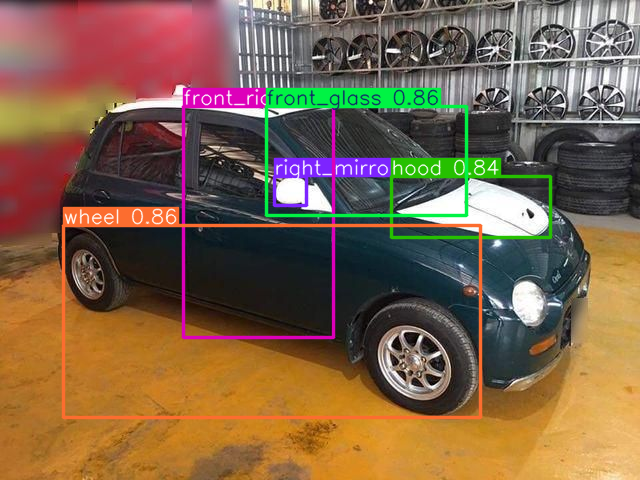


image 1/1 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/te30.jpg: 480x640 1 front_bumper, 1 front_glass, 2 front_right_lights, 1 hood, 2 right_mirrors, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Image: te30.jpg


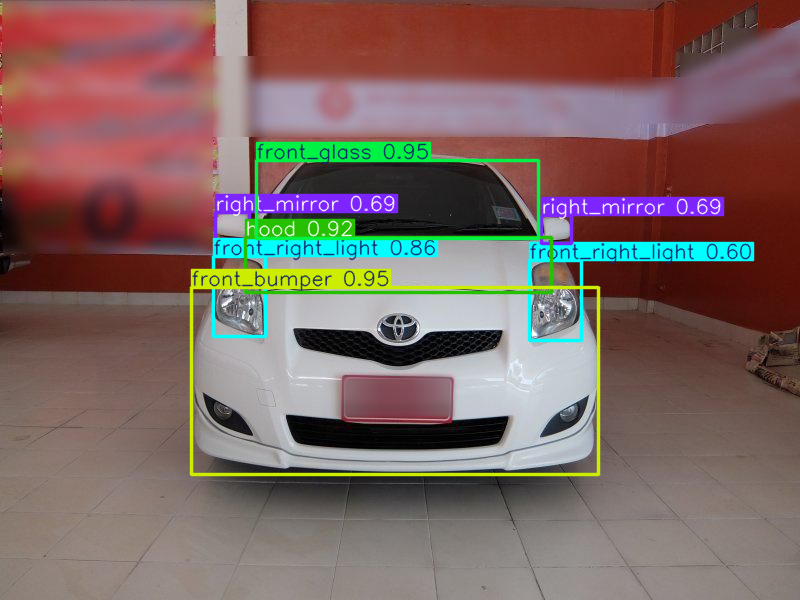


image 1/1 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car6.jpg: 640x640 1 back_left_door, 1 front_bumper, 1 front_glass, 1 front_left_door, 2 front_left_lights, 1 hood, 1 left_mirror, 1 wheel, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Image: car6.jpg


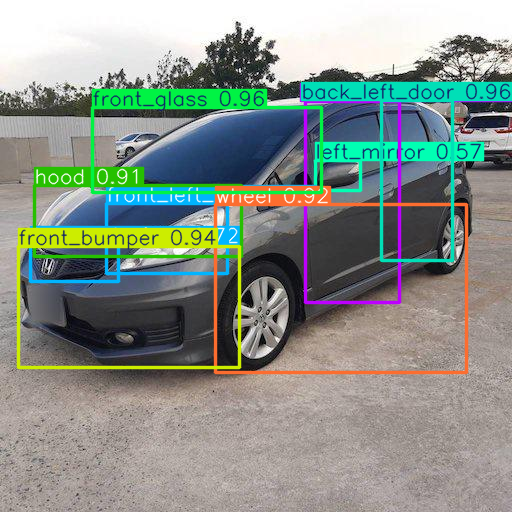


image 1/1 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/te93.jpg: 384x640 1 back_bumper, 1 back_right_door, 1 front_left_door, 1 front_right_light, 1 left_mirror, 1 wheel, 16.6ms
Speed: 2.7ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Image: te93.jpg


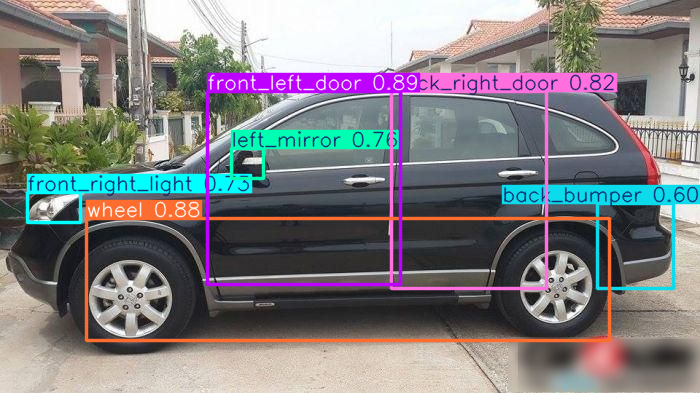


image 1/1 /teamspace/studios/this_studio/Car-Parts-Segmentation/testset/JPEGImages/car42.jpg: 640x640 1 back_bumper, 1 tailgate, 11.3ms
Speed: 2.5ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Image: car42.jpg


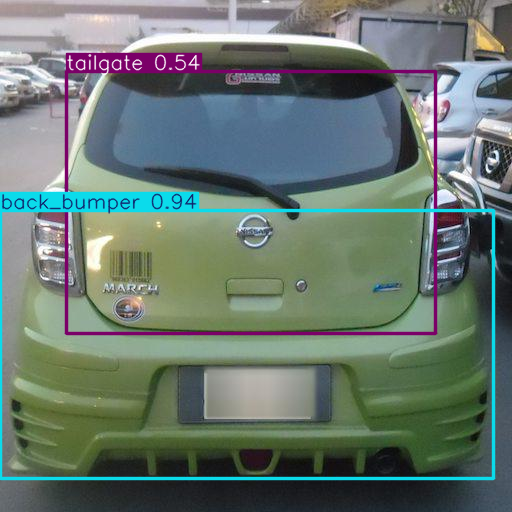

In [ ]:


test_images = [os.path.join(test_data, img) for img in os.listdir(test_data)]
random_images = random.sample(test_images, 5)

for img in random_images:
    prediction_results = model.predict(img, conf=0.5)
    img = os.path.basename(img)
    print("Image:", img)
    for result in prediction_results:
        result.show()

## Distribution of MaP values for different categories

In [ ]:


def generate_data_summary(results_val, results, train_annotation_file, test_annotation_file):
    maps = results_val.maps
    names = results_val.names
    coco_train = COCO(train_annotation_file)
    coco_test = COCO(test_annotation_file)

    class_counts = {}  

  
    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls = int(box.cls)  
            class_counts[cls] = class_counts.get(cls, 0) + 1  

    data = []

  
    for class_id, map_value in enumerate(maps):
        class_name = names[class_id]

        coco_class_id = class_id + 1

        train_ids = coco_train.getAnnIds(catIds=[coco_class_id])
        train_instances = len(train_ids)

        test_ids = coco_test.getAnnIds(catIds=[coco_class_id])
        test_instances = len(test_ids)

        predicted_instances = class_counts.get(class_id, 0)

        data.append({
            "Category ID": coco_class_id,
            "Category Name": class_name,
            "mAP": map_value,
            "Instances in Training": train_instances,
            "Instances in Testing": test_instances,
            "Instances in Prediction": predicted_instances
        })

    df = pd.DataFrame(data)
    df.sort_values(by="mAP", ascending=True, inplace=True)
    
    return df


df = generate_data_summary(results_val, results, train_annotation_file, test_annotation_file)


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
%matplotlib inline


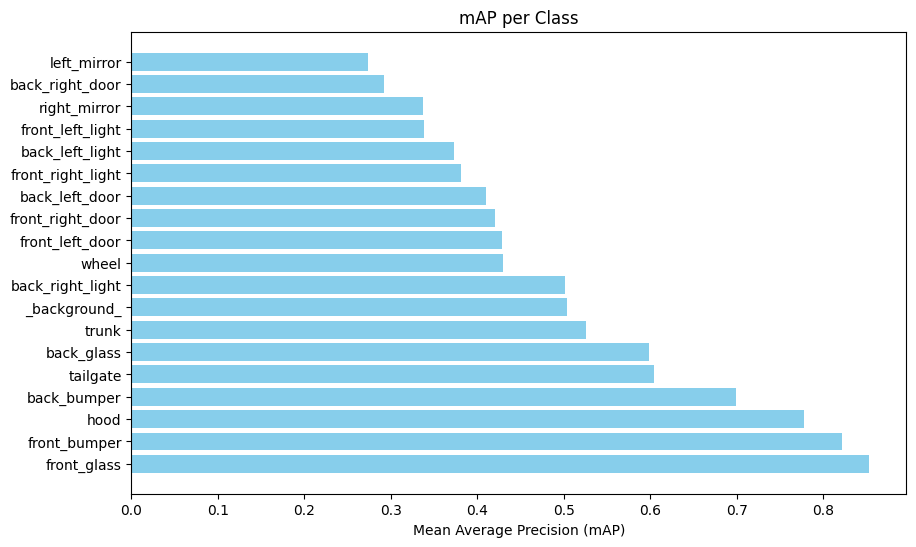

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


plt.barh(df['Category Name'], df['mAP'], color='skyblue')
plt.xlabel('Mean Average Precision (mAP)')
plt.title('mAP per Class')
plt.gca().invert_yaxis()  

plt.show()


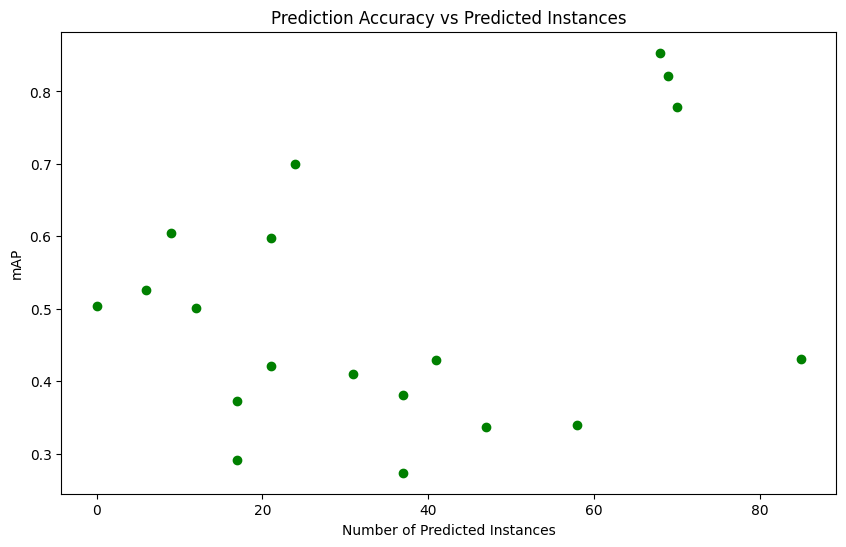

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Instances in Prediction'], df['mAP'], color='green')
plt.xlabel('Number of Predicted Instances')
plt.ylabel('mAP')
plt.title('Prediction Accuracy vs Predicted Instances')
plt.show()


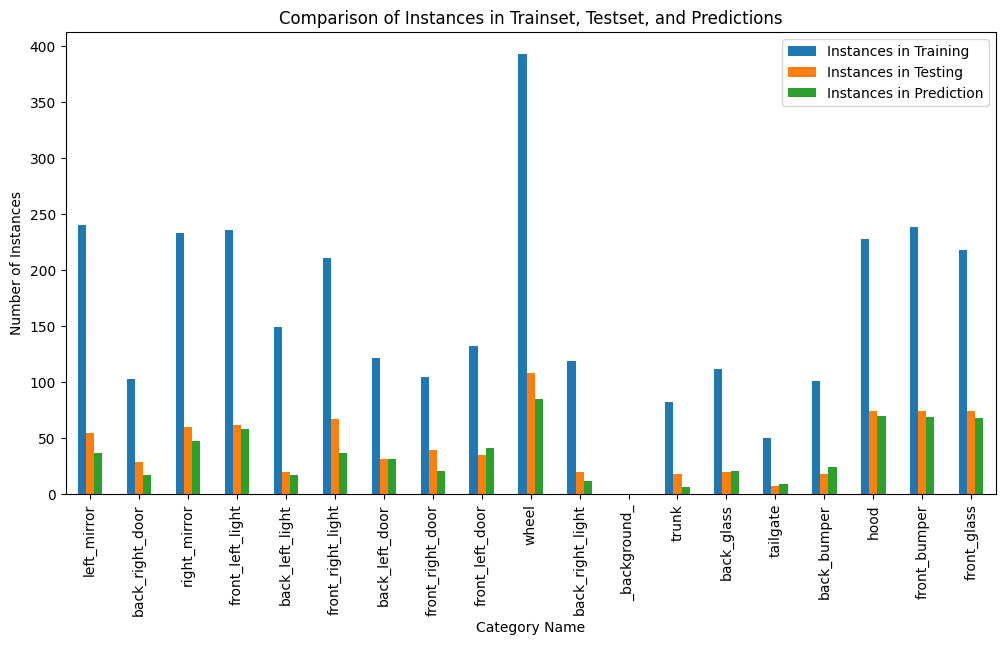

In [ ]:
df.set_index('Category Name')[['Instances in Training', 'Instances in Testing', 'Instances in Prediction']].plot(kind='bar', figsize=(12, 6))
plt.ylabel('Number of Instances')
plt.title('Comparison of Instances in Trainset, Testset, and Predictions')
plt.show()
